 # Importing Package

In [8]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from PIL import Image
import numpy as np
import keras
from tensorflow import lite
import tensorflow as tf
from keras.utils import to_categorical


# Sample Images

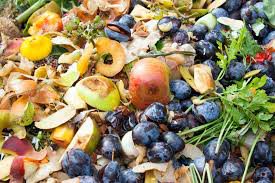

In [9]:
Image.open('/home/himanshu/Desktop/DATASET/Sample/index.jpeg')

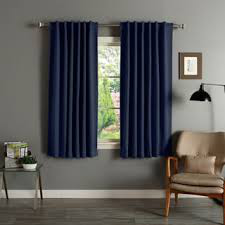

In [10]:
Image.open('/home/himanshu/Desktop/DATASET/TEST/R/R_10045.jpg')

# Convolutional Neural Network (CNN)

In [11]:
# Initialising the CNN
classifier = Sequential()

# Step 1 - Convolution
classifier.add(Conv2D(32, (3, 3), input_shape = (64, 64, 3),
                      activation = 'relu'))

# Step 2 - Pooling
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Adding a second convolutional layer
classifier.add(Conv2D(32, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Step 3 - Flattening
classifier.add(Flatten())

# Step 4 - Full connection
classifier.add(Dense(units = 128, activation = 'relu'))
classifier.add(Dense(units = 2, activation = 'softmax'))

# Compiling the CNN
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                   metrics = ['accuracy'])

# Loading DataSet 

In [12]:
train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [13]:
training_set = train_datagen.flow_from_directory('/home/himanshu/Desktop/DATASET/TRAIN',
                                                 target_size = (64, 64),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory('/home/himanshu/Desktop/DATASET/TEST',
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 22564 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.


In [14]:
# target Values
training_set.classes

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

# Training Model

In [15]:
classifier.fit_generator(training_set,
                         steps_per_epoch = 706,
                         epochs = 4,
                         validation_data = test_set,
                         validation_steps = 2000)

Instructions for updating:
Use tf.cast instead.
Epoch 1/4
706/706 [==============================] - 276s 390ms/step - loss: 0.4307 - acc: 0.8079 - val_loss: 0.4352 - val_acc: 0.8290
Epoch 2/4
706/706 [==============================] - 277s 392ms/step - loss: 0.3686 - acc: 0.8414 - val_loss: 0.2824 - val_acc: 0.8925
Epoch 3/4
706/706 [==============================] - 278s 394ms/step - loss: 0.3377 - acc: 0.8572 - val_loss: 0.3232 - val_acc: 0.8854
Epoch 4/4
706/706 [==============================] - 298s 422ms/step - loss: 0.3077 - acc: 0.8706 - val_loss: 0.2706 - val_acc: 0.8917


# Loading Test Image

In [16]:
# organic image
test_image = image.load_img('//home/himanshu/Desktop/DATASET/Sample/solid_wet_wastage.jpg',
                            target_size = (64, 64))

In [17]:
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)

# Prediction

In [18]:
result = classifier.predict(test_image)
result

array([[1., 0.]], dtype=float32)

# Labeling Target

In [19]:
training_set.class_indices

{'O': 0, 'R': 1}

In [20]:
if result[0][0] == 1:
    prediction = 'Recyclable/Dry'
else:
    prediction = 'Organic/Wet'

In [21]:
prediction

'Recyclable/Dry'

In [22]:
classifier.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               802944    
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 258       
Total para

# Save Keras Model

In [23]:
keras_classifier_model = 'waste_model.h5'

In [24]:
classifier.save(keras_classifier_model)

In [25]:
new_model = keras.models.load_model(keras_classifier_model)

In [26]:
new_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               802944    
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 258       
Total para

# Converting to .tflite Model

In [27]:
tflite_classifier_model = "waste_classifier_model.tflite"

In [28]:
converter = lite.TFLiteConverter.from_keras_model_file(keras_classifier_model)
tflite_model = converter.convert()
open(tflite_classifier_model, "wb").write(tflite_model)

Instructions for updating:
Use tf.compat.v1.graph_util.convert_variables_to_constants
Instructions for updating:
Use tf.compat.v1.graph_util.extract_sub_graph
INFO:tensorflow:Froze 8 variables.
INFO:tensorflow:Converted 8 variables to const ops.


3255488

In [29]:
interpreter = tf.contrib.lite.Interpreter(model_path=tflite_classifier_model)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [30]:
input_details

[{'name': 'conv2d_3_input',
  'index': 3,
  'shape': array([ 1, 64, 64,  3], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0)}]

In [31]:
output_details

[{'name': 'dense_4/Softmax',
  'index': 12,
  'shape': array([1, 2], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0)}]

In [32]:
result

array([[1., 0.]], dtype=float32)

# Interpreter 

In [33]:
input = interpreter.set_tensor(input_details[0]['index'], test_image)


In [34]:
interpreter.invoke()


In [35]:
output_data = interpreter.get_tensor(output_details[0]['index'])


In [36]:
print(output_data)

[[1.00000e+00 3.95065e-40]]
